#Preliminary operations

##Import libraries

In [1]:
# import main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# stats
from scipy import stats
#scaling, normalization
from sklearn.preprocessing import StandardScaler
# train, test, split
from sklearn.model_selection import train_test_split
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
# repeated stratified kfold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
# randomized and grid search cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Dummy clf
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions

##Mount Google Drive

In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import datasets

In [5]:
# import dataframe (without outliers)
df = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final.xlsx", index_col="Unnamed: 0")
df_emph_high = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final_emph_high.xlsx", index_col="Unnamed: 0")
df_emph_low = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final_emph_low.xlsx", index_col="Unnamed: 0")

In [ ]:
df.columns

Index(['vocal_channel', 'emotion', 'emotional_intensity', 'statement',
       'repetition', 'actor', 'sex', 'channels', 'length_ms', 'intensity',
       'zero_crossings_sum', 'mfcc_mean', 'mfcc_max', 'sc_mean', 'sc_std',
       'sc_min', 'sc_max', 'sc_kur', 'stft_mean', 'stft_std', 'stft_min',
       'stft_kur', 'mean', 'kur', 'skew', 'loudness', 'emotion_type'],
      dtype='object')

In [6]:
# get data columns
df_data = df.loc[:, "length_ms":"skew"]
df_data_emph_high = df_emph_high.loc[:, "length_ms":"skew"]
df_data_emph_low = df_emph_low.loc[:, "length_ms":"skew"]

# get values from data columns
X = df_data.values
X_emph_high = df_data_emph_high.values
X_emph_low = df_data_emph_low.values

# get emotion lables from each emphasis group
y_emotion = df["emotion"]
y_emotion_emph_high = df_emph_high["emotion"]
y_emotion_emph_low = df_emph_low["emotion"]

# get emotion type from each emphasis group
y_emtype = df["emotion_type"]
y_emtype_emph_high = df_emph_high["emotion_type"]
y_emtype_emph_low = df_emph_low["emotion_type"]

COSE DA FARE PER LA CLASSIFICAZIONE (PER OGNI MODELLO):

Le cose che facciamo le facciamo per tutti e 3 i dataset (all emphasis, high emphasis e low emphasis). Facciamo la classificazione per le due variabili che abbiamo usato anche nel Clustering: "emotions" e "emotional_type" (strong, weak).

* Dividere in "training_set" (80%) e "test_set" (20%)
* Usare il "training_set" per fare la Cross_Validation stratificata (Stratified Cross Validation) in 10 parti per testare gli iperparametri, con Grid-Search se non va troppo lento; se va lento usiamo Randomized-Search.
* Testare la classificazione su tutte e due le variabili dette prima, per ognuno dei 3 dataset che abbiamo
* Misuarci tutte le metriche possibili e immaginabili che ha fatto vedere lo Spinnnato in laboratorio
* Fine, basta, boh. Bona cisi e se un cisi bona

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [8]:
clf = KNeighborsClassifier(n_neighbors=44, metric="cityblock", weights="distance")

In [9]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint, loguniform

#Hyperparameters tuning (only on "emotion")

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X=None, y=y_train))
print(dummy_clf.score(X=None, y=y_test))

0.14737378888322283
0.1425661914460285


In [ ]:
# GridSearchCV
param_grid = {
    "criterion": ["gini", "entropy"],
    "min_samples_split": [0.2, 2, 20],
    "min_samples_leaf": [0.1, 1, 10],
    "max_depth": [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 40, 50, None],
}

grid = GridSearchCV(
    DecisionTreeClassifier(
        class_weight = "balanced",
        random_state = 0
    ),
    param_grid = param_grid,
    cv=RepeatedStratifiedKFold(
        n_splits = 20, 
        n_repeats = 3, 
        random_state = 0
    ),
    n_jobs = -1,
    refit = True
)

In [ ]:
# fit GridSearchCV
grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=20, random_state=0),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30,
                                       40, 50, None],
                         'min_samples_leaf': [0.1, 1, 10],
                         'min_samples_split': [0.2, 2, 20]})

In [ ]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.504839208410637
DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=0)


In [ ]:
clf = grid.best_estimator_
clf.score(X_test, y_test)

0.5213849287169042

#Emotions

##All emphasis

In [10]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [11]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.1425661914460285


In [12]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.63      0.61      0.62        75
        calm       0.49      0.63      0.55        75
     disgust       0.44      0.36      0.39        39
     fearful       0.40      0.37      0.39        75
       happy       0.35      0.36      0.35        75
     neutral       0.30      0.18      0.23        38
         sad       0.33      0.21      0.26        75
   surprised       0.32      0.59      0.42        39

    accuracy                           0.42       491
   macro avg       0.41      0.41      0.40       491
weighted avg       0.42      0.42      0.41       491



In [14]:
y_test_pred_proba = clf.predict_proba(X_test)

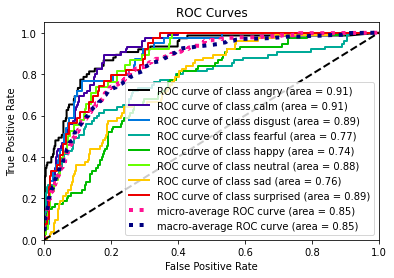

0.8447316637968048


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

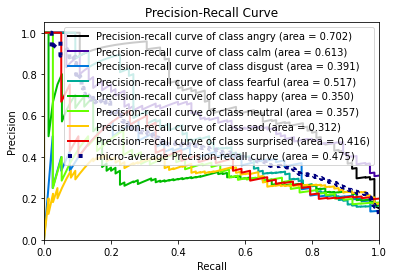

In [ ]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

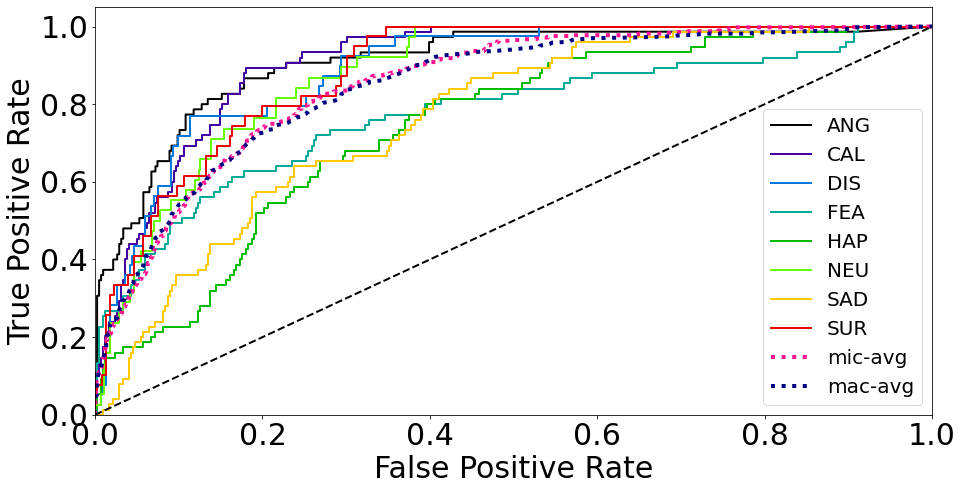

0.8447316637968048


In [15]:
plot_roc(y_test, clf.predict_proba(X_test), figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg", "mac-avg"], fontsize=20)

plt.savefig("clf_roc_curve.svg", format="svg")
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

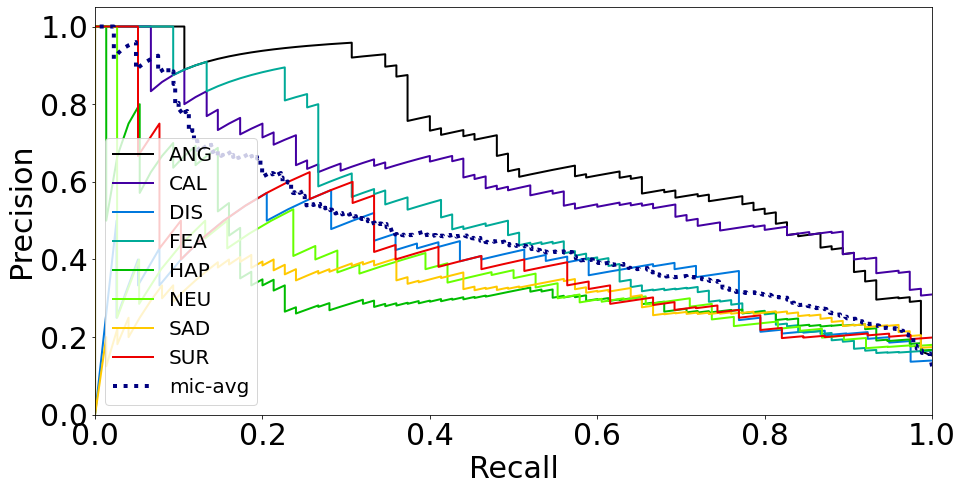

In [17]:

plot_precision_recall(y_test, clf.predict_proba(X_test), figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg"], fontsize=20)
plt.xlabel("Recall", fontsize=30)
plt.ylabel("Precision", fontsize=30)

plt.savefig("clf_precision_recall.svg", format="svg")
plt.show()

In [ ]:
import numpy as np
import pylab as pl
from sklearn import neighbors, datasets
import seaborn as sns

In [ ]:
sns.lineplot(
    data=results, x="param_n_neighbors", y="mean_test_score", hue="metric_weight"
)

NameError: ignored

##All emphasis (50% samples)

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    train_size=0.5,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.13441955193482688


In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.56      0.67      0.61        75
        calm       0.45      0.55      0.49        75
     disgust       0.30      0.31      0.30        39
     fearful       0.35      0.35      0.35        75
       happy       0.35      0.43      0.38        75
     neutral       0.53      0.21      0.30        38
         sad       0.22      0.15      0.18        75
   surprised       0.38      0.38      0.38        39

    accuracy                           0.40       491
   macro avg       0.39      0.38      0.37       491
weighted avg       0.39      0.40      0.38       491



In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)

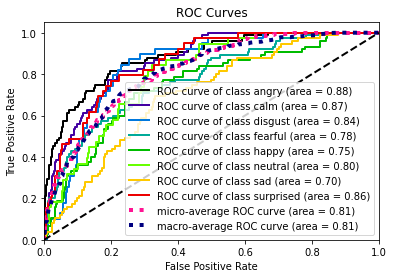

0.8097624319096738


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

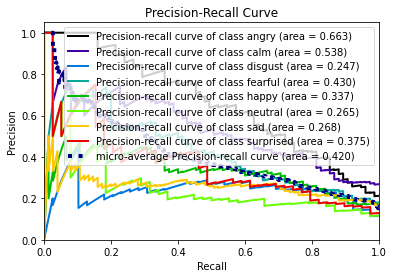

In [ ]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

##High emphasis

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

In [ ]:
# replacing training_set 
# (removing common samples between training_set and test_set)
X_train_index = df_data_emph_high.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_high.loc[X_train_index].values
y_train = y_emotion_emph_high[X_train_index]

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.1629327902240326


In [ ]:

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.65      0.48      0.55        75
        calm       0.39      0.61      0.48        75
     disgust       0.31      0.21      0.25        39
     fearful       0.44      0.37      0.40        75
       happy       0.33      0.36      0.35        75
     neutral       0.27      0.21      0.24        38
         sad       0.29      0.21      0.24        75
   surprised       0.34      0.54      0.42        39

    accuracy                           0.39       491
   macro avg       0.38      0.37      0.37       491
weighted avg       0.39      0.39      0.38       491



In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)

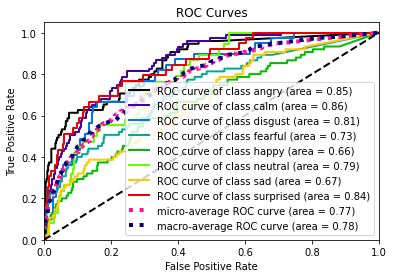

0.775208215203691


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

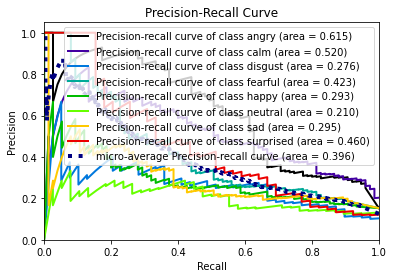

In [ ]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

##Low emphasis

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

In [ ]:
# split train- and test- set
X_train_index = df_data_emph_low.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_low.loc[X_train_index].values
y_train = y_emotion_emph_low[X_train_index]

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.14867617107942974


In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_train, y_train))
print(dummy_clf.score(X_test, y_test))

0.1377049180327869
0.14867617107942974


In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.41      0.73      0.53        75
        calm       0.59      0.27      0.37        75
     disgust       0.18      0.28      0.22        39
     fearful       0.32      0.23      0.27        75
       happy       0.19      0.17      0.18        75
     neutral       0.00      0.00      0.00        38
         sad       0.22      0.25      0.23        75
   surprised       0.15      0.21      0.17        39

    accuracy                           0.29       491
   macro avg       0.26      0.27      0.25       491
weighted avg       0.29      0.29      0.27       491



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)

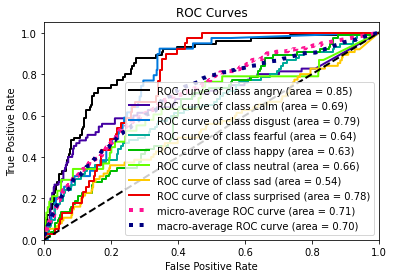

0.6971295332259497


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

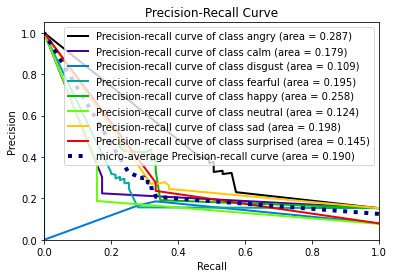

In [ ]:
plot_precision_recall(y_test, DT.predict_proba(X_test))
plt.show()

#Emotion type

##All emphasis

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.4969450101832994


In [ ]:

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      strong       0.83      0.90      0.86       303
        weak       0.81      0.70      0.75       188

    accuracy                           0.82       491
   macro avg       0.82      0.80      0.81       491
weighted avg       0.82      0.82      0.82       491



In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

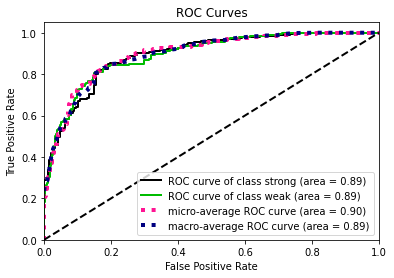

0.8933010322308825


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

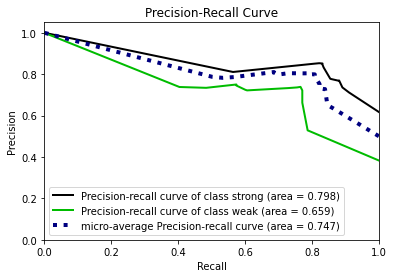

In [ ]:
plot_precision_recall(y_test, DT.predict_proba(X_test))
plt.show()

##All emphasis (50% samples)

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    train_size=0.5,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.5213849287169042


In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      strong       0.76      0.93      0.83       303
        weak       0.82      0.52      0.63       188

    accuracy                           0.77       491
   macro avg       0.79      0.72      0.73       491
weighted avg       0.78      0.77      0.76       491



In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

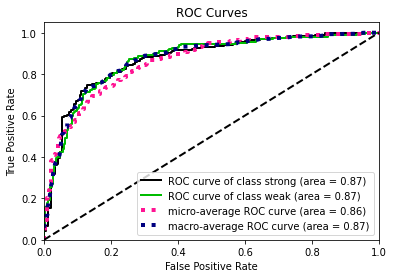

0.8710764693490626


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

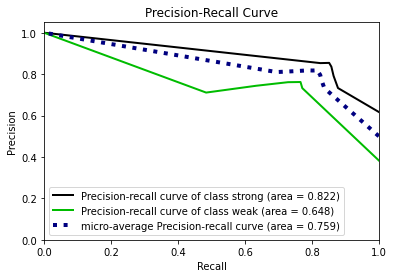

In [ ]:
plot_precision_recall(y_test, DT.predict_proba(X_test))
plt.show()

##High emphasis

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

In [ ]:
# split train- and test- set
X_train_index = df_data_emph_high.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_high.loc[X_train_index].values
y_train = y_emtype_emph_high[X_train_index]

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.49490835030549896


In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      strong       0.83      0.74      0.78       303
        weak       0.65      0.76      0.70       188

    accuracy                           0.75       491
   macro avg       0.74      0.75      0.74       491
weighted avg       0.76      0.75      0.75       491



In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

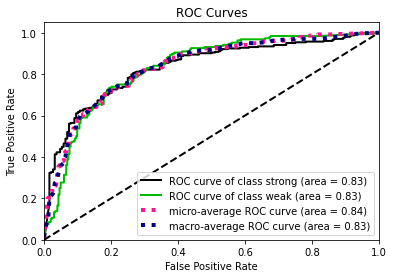

0.8326311354539709


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

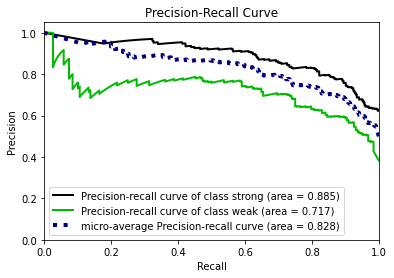

In [ ]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

##Low emphasis

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

In [ ]:
# split train- and test- set
X_train_index = df_data_emph_low.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_low.loc[X_train_index].values
y_train = y_emtype_emph_low[X_train_index]

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.4969450101832994


In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      strong       0.68      0.92      0.78       303
        weak       0.71      0.30      0.42       188

    accuracy                           0.68       491
   macro avg       0.69      0.61      0.60       491
weighted avg       0.69      0.68      0.64       491



In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

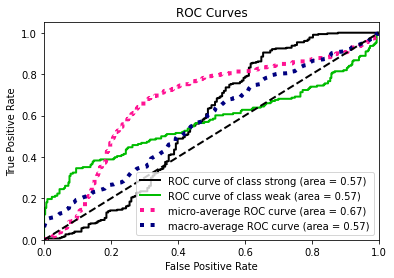

0.5712204199143318


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

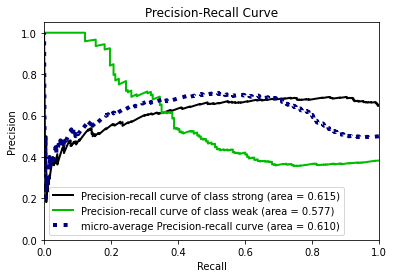

In [ ]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()